In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torchvision.models import resnet50, ResNet50_Weights,resnet152
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
testDir = 'Data/test'
trainDir = 'Data/train'
testFiles = os.listdir(testDir)
trainFiles = os.listdir(trainDir)

In [3]:
rawTestData = []
testDataLabels = []
rawTrainData = []
trainDataLabels = []

imgWidth, imgHeight = Image.open(testDir + '/' + testFiles[0]).size

for img in testFiles:
    label = os.path.splitext(img.split('_')[1])[0].lower()
    testDataLabels.append(label)
    imgData = Image.open(testDir + '/' + img)
    rawTestData.append(np.array(imgData))
    
for img in trainFiles:
    label = os.path.splitext(img.split('_')[1])[0].lower()
    trainDataLabels.append(label)
    imgData = Image.open(trainDir + '/' + img)
    rawTrainData.append(np.array(imgData))

In [4]:
normTestData = np.array(rawTestData)/255
normTrainData = np.array(rawTrainData)/255

In [5]:
reshapedTrainData = np.array([np.transpose(img, (2, 0, 1)) for img in normTrainData])
reshapedTestData = np.array([np.transpose(img, (2, 0, 1)) for img in normTestData])

In [6]:
print(reshapedTrainData.shape)

(8501, 3, 50, 250)


In [7]:
charSet = "0123456789abcdefghijklmnopqrstuvwxyz"
charToIndex = {char: i for i, char in enumerate(charSet)}
numClasses = len(charSet)

def labelToIndices(label):
    indices = [charToIndex[char] for char in label]
    return indices

In [8]:
testDataLabels = [x for x in testDataLabels]
encodedTestLabels = np.array([labelToIndices(label) for label in testDataLabels])

trainDataLabels = [x for x in trainDataLabels]
encodedTrainLabels = np.array([labelToIndices(label) for label in trainDataLabels])

In [9]:
encodedTestLabels_1, encodedTestLabels_2, encodedTestLabels_3, encodedTestLabels_4, encodedTestLabels_5, encodedTestLabels_6 = np.transpose(encodedTestLabels)
encodedTrainLabels_1, encodedTrainLabels_2, encodedTrainLabels_3, encodedTrainLabels_4, encodedTrainLabels_5, encodedTrainLabels_6 = np.transpose(encodedTrainLabels)

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:0 device


In [11]:
trainDataTensor = torch.tensor(reshapedTrainData)
trainLabel1Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_1])
trainLabel2Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_2])
trainLabel3Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_3])
trainLabel4Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_4])
trainLabel5Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_5])
trainLabel6Tensor = torch.stack([torch.tensor(x) for x in encodedTrainLabels_6])

testDataTensor = torch.tensor(reshapedTestData)
testLabel1Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_1])
testLabel2Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_2])
testLabel3Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_3])
testLabel4Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_4])
testLabel5Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_5])
testLabel6Tensor = torch.stack([torch.tensor(x) for x in encodedTestLabels_6])
# trainLabel1 = encodedTrainLabels_1

In [12]:
def test(dataloader, model, criterion):
    all_pred = []
    all_labels = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.type(torch.cuda.FloatTensor)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_pred.append(pred.argmax(1))
            all_labels.append(y)
    test_loss /= num_batches
    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Loss: {test_loss:>8f} \n")
    return all_pred, all_labels

In [13]:
def trainModel(trainDataloader, testDataloader):
    model = resnet152(weights="DEFAULT")
    model.fc = torch.nn.Linear(in_features=2048, out_features=36)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    torch.manual_seed(6868)
    model.to(device)
    num_epochs = 5  # Adjust as needed
    correct = 0
    
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(trainDataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.type(torch.cuda.FloatTensor)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        correct /= len(trainDataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {(100*correct):>0.1f}, Loss: {loss.item():.4f} \n')

        test(testDataloader, model, criterion)
        
    return model

In [14]:
trainLabelsTensors = [trainLabel1Tensor, trainLabel2Tensor, trainLabel3Tensor, trainLabel4Tensor, trainLabel5Tensor, trainLabel6Tensor]
testLabelsTensors = [testLabel1Tensor, testLabel2Tensor, testLabel3Tensor, testLabel4Tensor, testLabel5Tensor, testLabel6Tensor]
models = []

for trainLabelTensor, testLabelTensor in zip(trainLabelsTensors, testLabelsTensors):
    trainDataset = TensorDataset(trainDataTensor, trainLabelTensor)
    trainDataloader = DataLoader(trainDataset, batch_size=32, shuffle=True)
    testDataset = TensorDataset(testDataTensor, testLabelTensor)
    testDataloader = DataLoader(testDataset, batch_size=32)
    
    print("Training model 1 \n")
    models.append(trainModel(trainDataloader, testDataloader))

Training model 1 



Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 217MB/s]
100%|██████████| 266/266 [00:44<00:00,  6.03it/s]


Epoch [1/5], Accuracy: 68.2, Loss: 0.0367 

Test: 
 Accuracy: 98.2%, Loss: 0.062187 



100%|██████████| 266/266 [00:42<00:00,  6.32it/s]


Epoch [2/5], Accuracy: 96.4, Loss: 0.0176 

Test: 
 Accuracy: 98.8%, Loss: 0.060146 



100%|██████████| 266/266 [00:42<00:00,  6.32it/s]


Epoch [3/5], Accuracy: 98.6, Loss: 0.0078 

Test: 
 Accuracy: 98.9%, Loss: 0.048344 



100%|██████████| 266/266 [00:42<00:00,  6.33it/s]


Epoch [4/5], Accuracy: 98.6, Loss: 0.4258 

Test: 
 Accuracy: 99.3%, Loss: 0.029107 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [5/5], Accuracy: 98.9, Loss: 0.4041 

Test: 
 Accuracy: 99.1%, Loss: 0.049860 

Training model 1 



100%|██████████| 266/266 [00:42<00:00,  6.30it/s]


Epoch [1/5], Accuracy: 52.4, Loss: 0.1149 

Test: 
 Accuracy: 95.8%, Loss: 0.144616 



100%|██████████| 266/266 [00:41<00:00,  6.37it/s]


Epoch [2/5], Accuracy: 94.3, Loss: 0.0153 

Test: 
 Accuracy: 98.2%, Loss: 0.069500 



100%|██████████| 266/266 [00:41<00:00,  6.37it/s]


Epoch [3/5], Accuracy: 97.7, Loss: 0.0182 

Test: 
 Accuracy: 99.0%, Loss: 0.045301 



100%|██████████| 266/266 [00:41<00:00,  6.38it/s]


Epoch [4/5], Accuracy: 98.3, Loss: 0.0091 

Test: 
 Accuracy: 97.9%, Loss: 0.073005 



100%|██████████| 266/266 [00:41<00:00,  6.39it/s]


Epoch [5/5], Accuracy: 98.6, Loss: 0.0026 

Test: 
 Accuracy: 98.5%, Loss: 0.042029 

Training model 1 



100%|██████████| 266/266 [00:42<00:00,  6.33it/s]


Epoch [1/5], Accuracy: 49.3, Loss: 0.0727 

Test: 
 Accuracy: 93.8%, Loss: 0.198959 



100%|██████████| 266/266 [00:41<00:00,  6.40it/s]


Epoch [2/5], Accuracy: 93.9, Loss: 0.1838 

Test: 
 Accuracy: 97.5%, Loss: 0.100202 



100%|██████████| 266/266 [00:41<00:00,  6.40it/s]


Epoch [3/5], Accuracy: 97.4, Loss: 0.1450 

Test: 
 Accuracy: 96.9%, Loss: 0.122271 



100%|██████████| 266/266 [00:41<00:00,  6.41it/s]


Epoch [4/5], Accuracy: 98.5, Loss: 0.1739 

Test: 
 Accuracy: 97.8%, Loss: 0.085944 



100%|██████████| 266/266 [00:41<00:00,  6.41it/s]


Epoch [5/5], Accuracy: 98.6, Loss: 0.0061 

Test: 
 Accuracy: 98.3%, Loss: 0.074209 

Training model 1 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [1/5], Accuracy: 46.9, Loss: 0.1439 

Test: 
 Accuracy: 93.9%, Loss: 0.197786 



100%|██████████| 266/266 [00:41<00:00,  6.41it/s]


Epoch [2/5], Accuracy: 93.3, Loss: 0.3603 

Test: 
 Accuracy: 96.9%, Loss: 0.110361 



100%|██████████| 266/266 [00:41<00:00,  6.40it/s]


Epoch [3/5], Accuracy: 97.2, Loss: 0.0207 

Test: 
 Accuracy: 97.5%, Loss: 0.094590 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [4/5], Accuracy: 98.3, Loss: 0.0012 

Test: 
 Accuracy: 97.9%, Loss: 0.086016 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [5/5], Accuracy: 98.1, Loss: 0.0277 

Test: 
 Accuracy: 94.4%, Loss: 0.199567 

Training model 1 



100%|██████████| 266/266 [00:42<00:00,  6.28it/s]


Epoch [1/5], Accuracy: 54.4, Loss: 0.0563 

Test: 
 Accuracy: 95.1%, Loss: 0.164150 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [2/5], Accuracy: 94.4, Loss: 0.0102 

Test: 
 Accuracy: 97.8%, Loss: 0.075619 



100%|██████████| 266/266 [00:41<00:00,  6.34it/s]


Epoch [3/5], Accuracy: 97.8, Loss: 0.0015 

Test: 
 Accuracy: 96.7%, Loss: 0.118922 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [4/5], Accuracy: 98.2, Loss: 0.0035 

Test: 
 Accuracy: 98.3%, Loss: 0.063070 



100%|██████████| 266/266 [00:41<00:00,  6.35it/s]


Epoch [5/5], Accuracy: 99.0, Loss: 0.0558 

Test: 
 Accuracy: 98.4%, Loss: 0.060488 

Training model 1 



100%|██████████| 266/266 [00:41<00:00,  6.34it/s]


Epoch [1/5], Accuracy: 72.7, Loss: 0.0779 

Test: 
 Accuracy: 97.6%, Loss: 0.093626 



100%|██████████| 266/266 [00:41<00:00,  6.43it/s]


Epoch [2/5], Accuracy: 96.8, Loss: 0.1076 

Test: 
 Accuracy: 97.2%, Loss: 0.100979 



100%|██████████| 266/266 [00:41<00:00,  6.42it/s]


Epoch [3/5], Accuracy: 99.1, Loss: 0.0018 

Test: 
 Accuracy: 99.5%, Loss: 0.018643 



100%|██████████| 266/266 [00:41<00:00,  6.43it/s]


Epoch [4/5], Accuracy: 99.4, Loss: 0.2266 

Test: 
 Accuracy: 99.4%, Loss: 0.022540 



100%|██████████| 266/266 [00:41<00:00,  6.43it/s]


Epoch [5/5], Accuracy: 99.1, Loss: 0.0086 

Test: 
 Accuracy: 97.1%, Loss: 0.106408 



In [15]:
indexToChar = {i: char for i, char in enumerate(charSet)}

def indicesToLabel(lst):
    string = [indexToChar[idx] for idx in lst]
    return string

In [16]:
def combineOutputs(img):
    img = img.type(torch.cuda.FloatTensor)
    captcha = []
    for model in models:
        labelTensor = model(torch.unsqueeze(img, 0)).argmax(1)
        label = labelTensor.cpu().numpy()[0]
        captcha.append(label)
        
    captcha = indicesToLabel(captcha)
    captchaStr = ""
    for c in captcha: captchaStr += c
        
    return captchaStr

In [17]:
def testFullCaptcha(testDataTensor):
    predList = []
    for i in testDataTensor:
        predList.append(combineOutputs(i))
        
    correctPreds = 0
    for pred, actual in zip(predList, testDataLabels):
        if pred == actual:
            correctPreds += 1
    
    acc = correctPreds/len(predList)
    print(f'Accuracy: {acc*100}%')

In [18]:
testFullCaptcha(testDataTensor)

Accuracy: 86.53333333333333%


Predicted label: rfefnu
Real Label: rfefnu


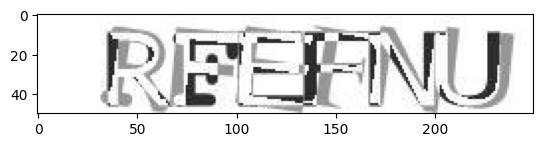

In [19]:
randCaptcha = random.randint(0, 1499)
print(f"Predicted label: {combineOutputs(testDataTensor[randCaptcha].to(device))}")
print(f"Real Label: {testDataLabels[randCaptcha]}")
plt.imshow(testDataTensor[randCaptcha].cpu().permute(1, 2, 0))